In [75]:
# analysis
# from https://blog.patricktriest.com/analyzing-cryptocurrencies-python/?utm_source=hackernews

In [3]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [5]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [6]:
# Pull Kraken BTC price exchange data
btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD')

Cached BCHARTS/KRAKENUSD at BCHARTS-KRAKENUSD.pkl


In [7]:
btc_usd_price_kraken.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


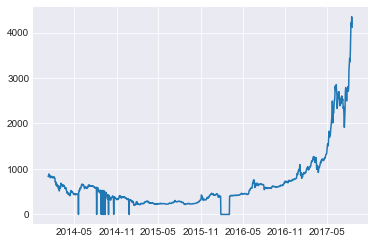

In [43]:
# Chart the BTC pricing data
# btc_trace = go.Scatter(x=btc_usd_price_kraken.index, y=btc_usd_price_kraken['Weighted Price'])
# py.iplot([btc_trace])
plt.plot(btc_usd_price_kraken['Weighted Price'])
plt.show()

In [9]:
# Pull pricing data for 3 more BTC exchanges
exchanges = ['COINBASE','BITSTAMP','ITBIT']

exchange_data = {}

exchange_data['KRAKEN'] = btc_usd_price_kraken

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df

Cached BCHARTS/COINBASEUSD at BCHARTS-COINBASEUSD.pkl
Cached BCHARTS/BITSTAMPUSD at BCHARTS-BITSTAMPUSD.pkl
Cached BCHARTS/ITBITUSD at BCHARTS-ITBITUSD.pkl


In [10]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [11]:
# Merge the BTC price dataseries' into a single dataframe
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')

In [12]:
btc_usd_datasets.tail()

,BITSTAMP,COINBASE,ITBIT,KRAKEN
Date,,,,
2017-08-16,4193.426713,4193.469553,4190.104520,4187.399662
2017-08-17,4338.694675,4334.115210,4334.449440,4346.508031
2017-08-18,4180.171091,4167.053043,4174.715155,4195.697579
2017-08-19,4030.604133,4096.284462,4052.981179,4121.371679
2017-08-20,4053.512769,4107.633990,4100.487971,4114.318980


In [13]:
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=visibility
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

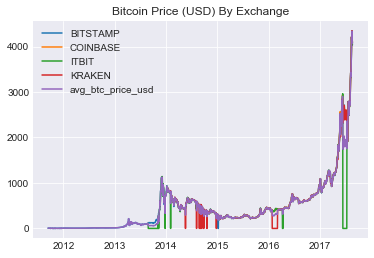

In [51]:
# Plot all of the BTC exchange prices
# df_scatter(btc_usd_datasets, 'Bitcoin Price (USD) By Exchange')
plt.plot(btc_usd_datasets)
plt.title('Bitcoin Price (USD) By Exchange')
plt.legend(btc_usd_datasets.columns)
plt.show()

In [15]:
# Calculate the average BTC price as a new column
btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)

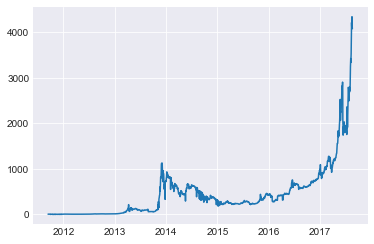

In [48]:
# Plot the average BTC price
# btc_trace = go.Scatter(x=btc_usd_datasets.index, y=btc_usd_datasets['avg_btc_price_usd'])
# py.iplot([btc_trace])
plt.plot(btc_usd_datasets['avg_btc_price_usd'])
plt.show()

In [17]:
def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

In [18]:
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
pediod = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), pediod)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

In [19]:
altcoins = ['ETH','LTC','XRP','ETC','STR','DASH','SC','XMR','XEM']

altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = crypto_price_df

Cached https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&start=1420088400.0&end=1503325228.257499&period=86400 at BTC_ETH
Cached https://poloniex.com/public?command=returnChartData&currencyPair=BTC_LTC&start=1420088400.0&end=1503325228.257499&period=86400 at BTC_LTC
Cached https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XRP&start=1420088400.0&end=1503325228.257499&period=86400 at BTC_XRP
Cached https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETC&start=1420088400.0&end=1503325228.257499&period=86400 at BTC_ETC
Cached https://poloniex.com/public?command=returnChartData&currencyPair=BTC_STR&start=1420088400.0&end=1503325228.257499&period=86400 at BTC_STR
Cached https://poloniex.com/public?command=returnChartData&currencyPair=BTC_DASH&start=1420088400.0&end=1503325228.257499&period=86400 at BTC_DASH
Cached https://poloniex.com/public?command=returnChartData&currencyPair=BTC_SC&start=1420088400.0&end=1503325228.257499&period=8

In [20]:
altcoin_data['ETH'].tail()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2017-08-17,0.070100,0.071150,0.068500,0.068760,138773.454089,9696.520545,0.069873
2017-08-18,0.071321,0.072906,0.069231,0.070200,153816.590806,10908.476511,0.070919
2017-08-19,0.070587,0.072988,0.070000,0.071321,179797.304636,12841.666823,0.071423
2017-08-20,0.073525,0.073710,0.070400,0.070690,100756.634696,7213.589872,0.071594
2017-08-21,0.083800,0.087044,0.071717,0.073500,334639.443759,26742.786745,0.079915


In [21]:
# Calculate USD Price as a new column in each altcoin dataframe
for altcoin in altcoin_data.keys():
    altcoin_data[altcoin]['price_usd'] =  altcoin_data[altcoin]['weightedAverage'] * btc_usd_datasets['avg_btc_price_usd']

In [22]:
# Merge USD price of each altcoin into single dataframe 
combined_df = merge_dfs_on_column(list(altcoin_data.values()), list(altcoin_data.keys()), 'price_usd')

In [23]:
# Add BTC price to the dataframe
combined_df['BTC'] = btc_usd_datasets['avg_btc_price_usd']

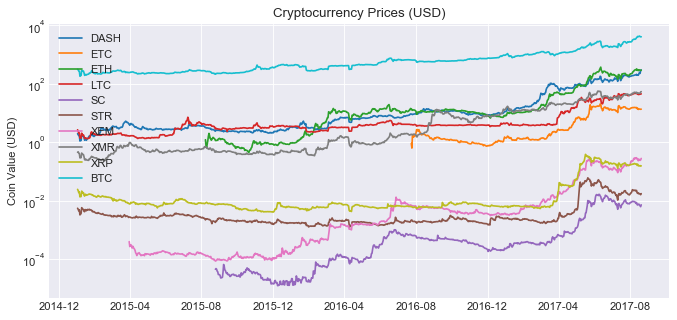

In [70]:
# Chart all of the altocoin prices
# df_scatter(combined_df, 'Cryptocurrency Prices (USD)', seperate_y_axis=False, y_axis_label='Coin Value (USD)', scale='log')
fig = plt.figure(figsize=(10,10), dpi=80)
ax = fig.add_subplot(2,1,1)
ax.plot(combined_df)
ax.set_yscale('log')
plt.legend(combined_df.columns, loc=0)
plt.title('Cryptocurrency Prices (USD)')
plt.ylabel('Coin Value (USD)')
plt.show()

In [25]:
# Calculate the pearson correlation coefficients for cryptocurrencies in 2016
combined_df_2016 = combined_df[combined_df.index.year == 2016]
combined_df_2016.corr(method='pearson')

,DASH,ETC,ETH,LTC,SC,STR,XEM,XMR,XRP,BTC
DASH,1.000000,0.420150,0.673332,0.567638,0.606049,0.545781,0.650359,0.699154,0.333131,0.706792
ETC,0.420150,1.000000,0.284055,-0.186238,0.643888,-0.138814,0.656708,-0.454081,-0.508740,-0.517899
ETH,0.673332,0.284055,1.000000,0.684508,0.701459,0.330639,0.541435,0.258918,0.442928,0.467297
LTC,0.567638,-0.186238,0.684508,1.000000,0.674092,0.230612,0.508911,0.280260,0.182942,0.724670
SC,0.606049,0.643888,0.701459,0.674092,1.000000,0.237319,0.862604,0.245606,0.142966,0.586587
STR,0.545781,-0.138814,0.330639,0.230612,0.237319,1.000000,0.354070,0.551481,0.612916,0.516555
XEM,0.650359,0.656708,0.541435,0.508911,0.862604,0.354070,1.000000,0.379255,0.156425,0.634466
XMR,0.699154,-0.454081,0.258918,0.280260,0.245606,0.551481,0.379255,1.000000,0.335421,0.686823
XRP,0.333131,-0.508740,0.442928,0.182942,0.142966,0.612916,0.156425,0.335421,1.000000,0.320969
BTC,0.706792,-0.517899,0.467297,0.724670,0.586587,0.516555,0.634466,0.686823,0.320969,1.000000


In [26]:
def correlation_heatmap(df, title, absolute_bounds=True):
    '''Plot a correlation heatmap for the entire dataframe'''
    heatmap = go.Heatmap(
        z=df.corr(method='pearson').as_matrix(),
        x=df.columns,
        y=df.columns,
        colorbar=dict(title='Pearson Coefficient'),
    )
    
    layout = go.Layout(title=title)
    
    if absolute_bounds:
        heatmap['zmax'] = 1.0
        heatmap['zmin'] = -1.0
        
    fig = go.Figure(data=[heatmap], layout=layout)
    py.iplot(fig)
    

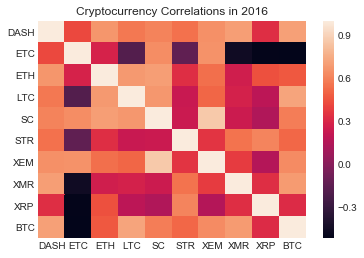

In [73]:
# correlation_heatmap(combined_df_2016, "Cryptocurrency Correlations in 2016")
sns.heatmap(combined_df_2016.corr(method='pearson'))
plt.title('Cryptocurrency Correlations in 2016')
plt.show()

In [28]:
combined_df_2017 = combined_df[combined_df.index.year == 2017]
combined_df_2017.corr(method='pearson')

,DASH,ETC,ETH,LTC,SC,STR,XEM,XMR,XRP,BTC
DASH,1.000000,0.874936,0.912633,0.915247,0.766646,0.566698,0.863164,0.930147,0.714426,0.911231
ETC,0.874936,1.000000,0.961311,0.910515,0.930372,0.732183,0.892410,0.940241,0.852593,0.849334
ETH,0.912633,0.961311,1.000000,0.902444,0.923307,0.698001,0.916950,0.955811,0.815757,0.903332
LTC,0.915247,0.910515,0.902444,1.000000,0.796473,0.659008,0.885714,0.905276,0.804102,0.892926
SC,0.766646,0.930372,0.923307,0.796473,1.000000,0.768733,0.839019,0.879472,0.852915,0.749236
STR,0.566698,0.732183,0.698001,0.659008,0.768733,1.000000,0.817721,0.763170,0.955119,0.612055
XEM,0.863164,0.892410,0.916950,0.885714,0.839019,0.817721,1.000000,0.952957,0.886821,0.929618
XMR,0.930147,0.940241,0.955811,0.905276,0.879472,0.763170,0.952957,1.000000,0.852333,0.923433
XRP,0.714426,0.852593,0.815757,0.804102,0.852915,0.955119,0.886821,0.852333,1.000000,0.726130
BTC,0.911231,0.849334,0.903332,0.892926,0.749236,0.612055,0.929618,0.923433,0.726130,1.000000


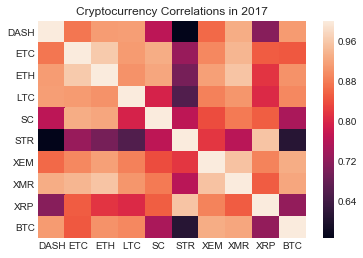

In [74]:
# correlation_heatmap(combined_df_2017, "Cryptocurrency Correlations in 2017")
sns.heatmap(combined_df_2017.corr(method='pearson'))
plt.title('Cryptocurrency Correlations in 2017')
plt.show()